In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Paths
csv_file = "C:\\Users\\iuser\\Downloads\\annotation.csv"
image_dir = "C:\\Users\\iuser\\Downloads\\dataset"
test_csv_file = "C:\\Users\\iuser\\Downloads\\test\\test_annotation.csv"
test_image_dir = "C:\\Users\\iuser\\Downloads\\test"
model_save_path = "C:\\Users\\iuser\\Downloads\\model\\resnet50_multiclass_building_detection.pth"
full_model_save_path = "C:\\Users\\iuser\\Downloads\\model\\resnet50_multiclass_building_detection_full.pth"

# Function to ensure directory is writable
def ensure_directory(path):
    directory = os.path.dirname(path)
    try:
        os.makedirs(directory, exist_ok=True)
        test_file = os.path.join(directory, "test_write.txt")
        with open(test_file, 'w') as f:
            f.write("test")
        os.remove(test_file)
        return True
    except (PermissionError, OSError) as e:
        print(f"Error: Cannot write to {directory}. {e}")
        return False

# Verify save directory
if not ensure_directory(model_save_path):
    print(f"Error: Save directory is not writable. Please specify a writable directory and update the save paths.")
    exit(1)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define all classes
all_classes = [
    "Block A: Admin Building", "Block B: Civil Department", "Block C: Old CS Department",
    "Block D: E&M Department", "Block E: Library", "Block F: New Building",
    "Old Cafe", "Juice Shop", "Security Office",
    "Highway", "Main Garden", "Parking", "Arm Wrestling Table", "Fountain",
    "Prayer Area", "TennisCourt", "Gate Two", "Gate Five"
]

# Custom Dataset
class MulticlassBuildingDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        try:
            self.df = pd.read_csv(csv_file)
        except Exception as e:
            print(f"Error reading CSV file {csv_file}: {e}")
            raise

        self.image_dir = image_dir
        self.transform = transform
        self.label_to_idx = {label: idx for idx, label in enumerate(all_classes)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

        # Remove duplicates (keep first occurrence)
        duplicates = self.df[self.df.duplicated(subset=['image_name'], keep='first')]
        if not duplicates.empty:
            print("Warning: Duplicate image names found in CSV. Keeping first occurrence:")
            print(duplicates[['image_name', 'label']].to_string(index=False))
            self.df = self.df.drop_duplicates(subset=['image_name'], keep='first')

        # Check class distribution
        class_counts = self.df['label'].value_counts()
        print("Class distribution in dataset:")
        for label, count in class_counts.items():
            print(f"- {label}: {count} images")

        # Check for missing images and filter
        self.valid_rows = []
        self.missing_images = []
        self.invalid_labels = []
        for idx in range(len(self.df)):
            img_name = self.df.iloc[idx]['image_name']
            label = self.df.iloc[idx]['label']
            img_path = os.path.join(self.image_dir, img_name)
            if os.path.exists(img_path):
                if label in self.label_to_idx:
                    self.valid_rows.append(idx)
                else:
                    self.invalid_labels.append((img_name, label))
            else:
                self.missing_images.append(img_name)

        if self.missing_images:
            print("Warning: The following images are listed in CSV but missing in dataset:")
            for img in self.missing_images[:10]:
                print(f"- {img}")
            if len(self.missing_images) > 10:
                print(f"... and {len(self.missing_images) - 10} more.")

        if self.invalid_labels:
            print("Warning: The following images have invalid labels not in the defined classes:")
            for img_name, label in self.invalid_labels[:10]:
                print(f"- {img_name}: {label}")
            if len(self.invalid_labels) > 10:
                print(f"... and {len(self.invalid_labels) - 10} more.")

        print(f"Proceeding with {len(self.valid_rows)} valid images (out of {len(self.df)} in CSV).")

    def __len__(self):
        return len(self.valid_rows)

    def __getitem__(self, idx):
        actual_idx = self.valid_rows[idx]
        img_name = self.df.iloc[actual_idx]['image_name']
        img_path = os.path.join(self.image_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            raise FileNotFoundError(f"Image {img_name} not found at {img_path}")

        label = self.df.iloc[actual_idx]['label']
        label_idx = self.label_to_idx[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
try:
    dataset = MulticlassBuildingDataset(csv_file, image_dir)
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit(1)

if len(dataset) == 0:
    print("Error: No valid images found. Please check the dataset and CSV.")
    exit(1)

# Stratified train-validation split
labels = [dataset.df.iloc[idx]['label'] for idx in dataset.valid_rows]
train_indices, val_indices = train_test_split(
    range(len(dataset.valid_rows)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

# Load pretrained ResNet50 and modify for 18 classes
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, len(all_classes))
)
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Training loop
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total if total > 0 else 0
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
    val_accuracy = 100 * correct / total if total > 0 else 0
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Compute metrics
    precision, recall, f1 = 0, 0, 0
    per_class_precision, per_class_recall, per_class_f1 = None, None, None
    if len(all_labels) > 0:
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
        per_class_precision, per_class_recall, per_class_f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average=None, zero_division=0, labels=range(len(all_classes))
        )

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    print(f"Weighted Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    if per_class_precision is not None:
        print("Per-class metrics:")
        for idx, label in enumerate(all_classes):
            print(f"  {label}: Precision={per_class_precision[idx]:.4f}, Recall={per_class_recall[idx]:.4f}, F1={per_class_f1[idx]:.4f}")
    print()

    # Step scheduler
    scheduler.step(val_loss)

# Save the retrained model
try:
    torch.save(model.state_dict(), model_save_path)
    print(f"Model state dictionary saved to {model_save_path}")
except Exception as e:
    print(f"Error saving model state dictionary: {e}")

try:
    torch.save(model, full_model_save_path)
    print(f"Full model saved to {full_model_save_path}")
except Exception as e:
    print(f"Error saving full model: {e}")

# Verify saved models
if os.path.exists(model_save_path):
    print(f"Verified: {model_save_path} exists (size: {os.path.getsize(model_save_path) / (1024 * 1024):.2f} MB)")
else:
    print(f"Warning: {model_save_path} was not found.")

if os.path.exists(full_model_save_path):
    print(f"Verified: {full_model_save_path} exists (size: {os.path.getsize(full_model_save_path) / (1024 * 1024):.2f} MB)")
else:
    print(f"Warning: {full_model_save_path} was not found.")

# Compute Confusion Matrix for Validation Set
def compute_confusion_matrix(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(all_classes)))
    return cm, all_preds, all_labels

# Validation confusion matrix
cm_val, val_preds, val_labels = compute_confusion_matrix(model, val_loader, device)
print("\nValidation Confusion Matrix:")
print(cm_val)

# Plot validation confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=all_classes, yticklabels=all_classes)
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(os.path.dirname(model_save_path), 'val_confusion_matrix_multiclass.png'))
print(f"Validation confusion matrix plot saved as '{os.path.join(os.path.dirname(model_save_path), 'val_confusion_matrix_multiclass.png')}'")
plt.close()

# Test Dataset Evaluation (only if test CSV exists)
if os.path.exists(test_csv_file):
    try:
        test_dataset = MulticlassBuildingDataset(test_csv_file, test_image_dir, transform=val_transform)
    except Exception as e:
        print(f"Error loading test dataset: {e}")
        test_dataset = None

    if test_dataset and len(test_dataset) > 0:
        test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0)

        # Debug test_loader output
        try:
            for batch in test_loader:
                print(f"Test batch contents: {len(batch)} elements")
                for i, item in enumerate(batch):
                    print(f"Item {i}: type={type(item)}, shape={item.shape if hasattr(item, 'shape') else 'N/A'}")
                break  # Only check the first batch
        except Exception as e:
            print(f"Error inspecting test_loader: {e}")

        # Evaluate on test dataset
        def evaluate_test_set(model, test_loader, device, criterion):
            model.eval()
            test_loss = 0.0
            correct = 0
            total = 0
            all_preds, all_labels = [], []
            try:
                with torch.no_grad():
                    for batch in test_loader:
                        if len(batch) != 2:
                            raise ValueError(f"Expected 2 elements in batch (images, labels), got {len(batch)}")
                        images, labels = batch
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        test_loss += loss.item()

                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                        all_preds.extend(predicted.cpu().numpy())
                        all_labels.extend(labels.cpu().numpy())
            except Exception as e:
                print(f"Error during test evaluation: {e}")
                return None, None, None, None, None, None, None, None

            test_loss = test_loss / len(test_loader) if len(test_loader) > 0 else 0
            test_accuracy = 100 * correct / total if total > 0 else 0
            precision, recall, f1 = 0, 0, 0
            per_class_precision, per_class_recall, per_class_f1 = None, None, None
            if len(all_labels) > 0:
                precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
                per_class_precision, per_class_recall, per_class_f1, _ = precision_recall_fscore_support(
                    all_labels, all_preds, average=None, zero_division=0, labels=range(len(all_classes))
                )

            cm_test = confusion_matrix(all_labels, all_preds, labels=range(len(all_classes)))
            return test_loss, test_accuracy, precision, recall, f1, cm_test, all_preds, all_labels, per_class_precision, per_class_recall, per_class_f1

        # Run evaluation on test set
        result = evaluate_test_set(model, test_loader, device, criterion)
        if result[0] is not None:
            test_loss, test_accuracy, test_precision, test_recall, test_f1, cm_test, test_preds, test_labels, per_class_precision, per_class_recall, per_class_f1 = result

            # Print test results
            print("\nTest Set Results:")
            print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
            print(f"Weighted Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
            if per_class_precision is not None:
                print("Per-class metrics:")
                for idx, label in enumerate(all_classes):
                    print(f"  {label}: Precision={per_class_precision[idx]:.4f}, Recall={per_class_recall[idx]:.4f}, F1={per_class_f1[idx]:.4f}")
            print("\nTest Confusion Matrix:")
            print(cm_test)

            # Plot test confusion matrix
            plt.figure(figsize=(12, 10))
            sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=all_classes, yticklabels=all_classes)
            plt.title('Test Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.savefig(os.path.join(os.path.dirname(model_save_path), 'test_confusion_matrix_multiclass.png'))
            print(f"Test confusion matrix plot saved as '{os.path.join(os.path.dirname(model_save_path), 'test_confusion_matrix_multiclass.png')}'")
            plt.close()
        else:
            print("Skipping test dataset evaluation: Failed to process test_loader.")
    else:
        print("Skipping test dataset evaluation: No valid images found in test dataset.")
else:
    print(f"Skipping test dataset evaluation: Test CSV file not found at {test_csv_file}")

# Plot training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(os.path.dirname(model_save_path), 'multiclass_training_metrics.png'))
print(f"Training metrics plot saved as '{os.path.join(os.path.dirname(model_save_path), 'multiclass_training_metrics.png')}'")
plt.close()

Using device: cuda
   image_name     label
GateFive4.jpg Gate Five
Class distribution in dataset:
- Block A: Admin Building: 14 images
- Block F: New Building: 14 images
- Parking: 14 images
- Block B: Civil Department: 13 images
- Highway: 13 images
- Block E: Library: 12 images
- Main Garden: 12 images
- TennisCourt: 11 images
- Juice Shop: 11 images
- Old Cafe: 10 images
- Prayer Area: 9 images
- Gate Five: 8 images
- Arm Wrestling Table: 8 images
- Fountain: 8 images
- Gate Two: 8 images
- Block D: E&M Department: 7 images
- Security Office: 6 images
- Block C: Old CS Department: 6 images
Proceeding with 184 valid images (out of 184 in CSV).
Epoch [1/10]
Train Loss: 2.6375, Train Accuracy: 24.49%
Val Loss: 1.6438, Val Accuracy: 72.97%
Weighted Precision: 0.6487, Recall: 0.7297, F1: 0.6618
Per-class metrics:
  Block A: Admin Building: Precision=0.6000, Recall=1.0000, F1=0.7500
  Block B: Civil Department: Precision=0.7500, Recall=1.0000, F1=0.8571
  Block C: Old CS Department: Preci

In [ ]:
import os
import pandas as pd

# Paths
csv_file = "C:\\Users\\iuser\\Downloads\\annotation.csv"  # Updated CSV path
image_dir = "C:\\Users\\iuser\\Downloads\\dataset"

# Read the CSV file
try:
    df = pd.read_csv(csv_file)
    csv_images = set(df['image_name'].tolist())  # Get unique image names from CSV
except FileNotFoundError:
    print("Error: annotation.csv not found at the specified path.")
    exit(1)

# Get list of image files in the directory
try:
    dir_images = set(f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png')))
except FileNotFoundError:
    print("Error: Image directory not found at the specified path.")
    exit(1)

# Compare the two sets
missing_in_dir = csv_images - dir_images  # Images in CSV but not in directory
extra_in_dir = dir_images - csv_images   # Images in directory but not in CSV

# Report results
print("Checking images...")
print(f"Total images in CSV: {len(csv_images)}")
print(f"Total images in directory: {len(dir_images)}")

if missing_in_dir:
    print("\nImages listed in CSV but missing in directory:")
    for img in sorted(missing_in_dir):
        print(f"- {img}")
else:
    print("\nAll images from CSV are present in the directory.")

if extra_in_dir:
    print("\nImages in directory but not listed in CSV:")
    for img in sorted(extra_in_dir):
        print(f"- {img}")
else:
    print("\nNo extra images found in the directory.")

if not missing_in_dir and not extra_in_dir:
    print("\nAll images are OK: The directory matches the CSV perfectly.")

Checking images...
Total images in CSV: 184
Total images in directory: 184

All images from CSV are present in the directory.

No extra images found in the directory.

All images are OK: The directory matches the CSV perfectly.


In [ ]:
import os
import torch
from torchvision import models, transforms
from PIL import Image
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Paths
model_path = "C:\\Users\\iuser\\Downloads\\model\\resnet50_building_detection.pth"
csv_file = "C:\\Users\\iuser\\Downloads\\annotation.csv"  # For label mapping
test_dir = "C:\\Users\\iuser\\Downloads\\test"
output_csv = "C:\\Users\\iuser\\Downloads\\test_predictions.csv"
test_csv = None  # Set to the path of a test CSV with labels, e.g., "C:\\Users\\iuser\\Downloads\\test_annotation.csv"

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load label mapping
try:
    df = pd.read_csv(csv_file)
    labels = sorted(df['label'].unique())
    label_to_idx = {label: idx for idx, label in enumerate(labels)}
    idx_to_label = {idx: label for label, idx in label_to_idx.items()}
except FileNotFoundError:
    print(f"Error: {csv_file} not found.")
    exit(1)

# Load model
try:
    model = models.resnet50(pretrained=False)
    num_classes = len(labels)
    model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    print(f"Loaded model from {model_path}")
except FileNotFoundError:
    print(f"Error: {model_path} not found.")
    exit(1)
except Exception as e:
    print(f"Error loading model: {e}")
    exit(1)

# Transform for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load test CSV (if provided)
test_labels = None
if test_csv:
    try:
        test_df = pd.read_csv(test_csv)
        test_labels = {row['image_name']: row['label'] for _, row in test_df.iterrows()}
    except FileNotFoundError:
        print(f"Warning: {test_csv} not found. Proceeding without ground truth labels.")
        test_labels = None

# Get test images
test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
if not test_images:
    print(f"Error: No images found in {test_dir}.")
    exit(1)

# Predict and evaluate
predictions = []
true_labels = []
results = []

print("\nPredicting on test images...")
for img_name in test_images:
    img_path = os.path.join(test_dir, img_name)
    try:
        # Load and preprocess image
        image = Image.open(img_path).convert('RGB')
        image = transform(image).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            output = model(image)
            _, predicted_idx = torch.max(output, 1)
            predicted_label = idx_to_label[predicted_idx.item()]

        # Store result
        results.append({'image_name': img_name, 'predicted_label': predicted_label})
        predictions.append(predicted_label)

        # If test CSV is provided, get true label
        if test_labels and img_name in test_labels:
            true_label = test_labels[img_name]
            true_labels.append(true_label)

        print(f"Image: {img_name}, Predicted Label: {predicted_label}")
    except Exception as e:
        print(f"Error processing {img_name}: {e}")

# Save predictions to CSV
results_df = pd.DataFrame(results)
try:
    results_df.to_csv(output_csv, index=False)
    print(f"\nPredictions saved to {output_csv}")
except Exception as e:
    print(f"Error saving predictions: {e}")

# Evaluate if ground truth labels are available
if test_labels and len(true_labels) == len(predictions):
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    print("\nTest Set Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
elif test_labels:
    print("\nWarning: Some test images are missing ground truth labels. Metrics not computed.")
else:
    print("\nNo test CSV provided. Metrics not computed.")

Using device: cuda
Loaded model from C:\Users\iuser\Downloads\model\resnet50_building_detection.pth

Predicting on test images...
Image: ArmWrestlingTable1.jpg, Predicted Label: Block B: Civil Department
Image: ArmWrestlingTable2.jpg, Predicted Label: Arm Wrestling Table
Image: ArmWrestlingTable3.jpg, Predicted Label: Gate Five
Image: Fountain1.jpg, Predicted Label: Block B: Civil Department
Image: Fountain2.jpg, Predicted Label: Block B: Civil Department
Image: Fountain3.jpg, Predicted Label: Block B: Civil Department
Image: GateFive1.jpg, Predicted Label: Gate Five
Image: GateFive2.jpg, Predicted Label: Gate Five
Image: GateFive3.jpg, Predicted Label: Gate Five
Image: GateTwo1.jpg, Predicted Label: Old Cafe
Image: GateTwo2.jpg, Predicted Label: Block F: New Building
Image: GateTwo3.jpg, Predicted Label: Old Cafe
Image: JuiceShop1.jpg, Predicted Label: Juice Shop
Image: JuiceShop2.jpg, Predicted Label: Juice Shop
Image: JuiceShop3.jpg, Predicted Label: Gate Five
Image: PrayerArea1.jpg

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

In [ ]:
scheduler = optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=1e-5,          # Minimum learning rate
    max_lr=1e-3,           # Maximum learning rate
    step_size_up=500,      # Iterations for increasing phase
    step_size_down=None,   # Defaults to step_size_up if None
    cycle_momentum=False,   # Disable momentum cycling for Adam
    mode='triangular'      # Learning rate policy
)

In [ ]:
# Use SGD optimizer with momentum
optimizer = optim.SGD(
    model.parameters(),
    lr=1e-3,           # Initial learning rate (will be overridden by CyclicLR)
    momentum=0.9,      # Default momentum
    weight_decay=1e-3
)

# CyclicLR scheduler with momentum cycling
scheduler = optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=1e-5,
    max_lr=1e-3,
    step_size_up=500,
    step_size_down=None,
    cycle_momentum=True,      # Enable momentum cycling
    base_momentum=0.8,        # Minimum momentum
    max_momentum=0.9,         # Maximum momentum
    mode='triangular'
)

In [ ]:
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=10,          # Number of epochs for one cosine cycle
    eta_min=1e-6       # Minimum learning rate
)

In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Paths
csv_file = "C:\\Users\\iuser\\Downloads\\annotation.csv"
image_dir = "C:\\Users\\iuser\\Downloads\\dataset"
test_csv_file = "C:\\Users\\iuser\\Downloads\\test_annotation.csv"
test_image_dir = "C:\\Users\\iuser\\Downloads\\test"
model_save_path = "C:\\Users\\iuser\\Downloads\\model\\resnet50_multiclass_building_detection.pth"
full_model_save_path = "C:\\Users\\iuser\\Downloads\\model\\resnet50_multiclass_building_detection_full.pth"

# Function to ensure directory is writable
def ensure_directory(path):
    directory = os.path.dirname(path)
    try:
        os.makedirs(directory, exist_ok=True)
        test_file = os.path.join(directory, "test_write.txt")
        with open(test_file, 'w') as f:
            f.write("test")
        os.remove(test_file)
        return True
    except (PermissionError, OSError) as e:
        print(f"Error: Cannot write to {directory}. {e}")
        return False

# Verify save directory
if not ensure_directory(model_save_path):
    print(f"Error: Save directory is not writable. Please specify a writable directory and update the save paths.")
    exit(1)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define all classes
all_classes = [
    "Block A: Admin Building", "Block B: Civil Department", "Block C: Old CS Department",
    "Block D: E&M Department", "Block E: Library", "Block F: New Building",
    "Old Cafe", "Juice Shop", "Security Office",
    "Highway", "Main Garden", "Parking", "Arm Wrestling Table", "Fountain",
    "Prayer Area", "TennisCourt", "Gate Two", "Gate Five"
]

# Custom Dataset
class MulticlassBuildingDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        try:
            self.df = pd.read_csv(csv_file)
        except Exception as e:
            print(f"Error reading CSV file {csv_file}: {e}")
            raise

        self.image_dir = image_dir
        self.transform = transform
        self.label_to_idx = {label: idx for idx, label in enumerate(all_classes)}
        self.idx_to_label = {idx: label for label, idx in self.label_to_idx.items()}

        # Remove duplicates (keep first occurrence)
        duplicates = self.df[self.df.duplicated(subset=['image_name'], keep='first')]
        if not duplicates.empty:
            print("Warning: Duplicate image names found in CSV. Keeping first occurrence:")
            print(duplicates[['image_name', 'label']].to_string(index=False))
            self.df = self.df.drop_duplicates(subset=['image_name'], keep='first')

        # Check class distribution
        class_counts = self.df['label'].value_counts()
        print("Class distribution in dataset:")
        for label, count in class_counts.items():
            print(f"- {label}: {count} images")

        # Check for missing images and filter
        self.valid_rows = []
        self.missing_images = []
        self.invalid_labels = []
        for idx in range(len(self.df)):
            img_name = self.df.iloc[idx]['image_name']
            label = self.df.iloc[idx]['label']
            img_path = os.path.join(self.image_dir, img_name)
            if os.path.exists(img_path):
                if label in self.label_to_idx:
                    self.valid_rows.append(idx)
                else:
                    self.invalid_labels.append((img_name, label))
            else:
                self.missing_images.append(img_name)

        if self.missing_images:
            print("Warning: The following images are listed in CSV but missing in dataset:")
            for img in self.missing_images[:10]:
                print(f"- {img}")
            if len(self.missing_images) > 10:
                print(f"... and {len(self.missing_images) - 10} more.")

        if self.invalid_labels:
            print("Warning: The following images have invalid labels not in the defined classes:")
            for img_name, label in self.invalid_labels[:10]:
                print(f"- {img_name}: {label}")
            if len(self.invalid_labels) > 10:
                print(f"... and {len(self.invalid_labels) - 10} more.")

        print(f"Proceeding with {len(self.valid_rows)} valid images (out of {len(self.df)} in CSV).")

    def __len__(self):
        return len(self.valid_rows)

    def __getitem__(self, idx):
        actual_idx = self.valid_rows[idx]
        img_name = self.df.iloc[actual_idx]['image_name']
        img_path = os.path.join(self.image_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except FileNotFoundError:
            raise FileNotFoundError(f"Image {img_name} not found at {img_path}")

        label = self.df.iloc[actual_idx]['label']
        label_idx = self.label_to_idx[label]

        if self.transform:
            image = self.transform(image)

        return image, label_idx

# Enhanced data transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.7, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset
try:
    dataset = MulticlassBuildingDataset(csv_file, image_dir)
except FileNotFoundError as e:
    print(f"Error: {e}")
    exit(1)

if len(dataset) == 0:
    print("Error: No valid images found. Please check the dataset and CSV.")
    exit(1)

# Stratified train-validation split
labels = [dataset.df.iloc[idx]['label'] for idx in dataset.valid_rows]
train_indices, val_indices = train_test_split(
    range(len(dataset.valid_rows)),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

# Load pretrained ResNet50 and modify for 18 classes
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(0.7),  # Increased dropout
    nn.Linear(num_ftrs, len(all_classes))
)
model = model.to(device)

# Compute class weights for imbalanced classes
class_counts = dataset.df.iloc[dataset.valid_rows]['label'].value_counts()
class_weights = torch.FloatTensor([1.0 / class_counts[dataset.idx_to_label[i]] for i in range(len(all_classes))]).to(device)

# Loss and optimizer with label smoothing
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-3)

# CyclicLR scheduler
scheduler = optim.lr_scheduler.CyclicLR(
    optimizer,
    base_lr=1e-5,
    max_lr=1e-3,
    step_size_up=30,  # Adjusted for small dataset (~9 iterations/epoch)
    step_size_down=None,
    cycle_momentum=False,  # Disabled for Adam
    mode='triangular'
)

# Training loop with early stopping
num_epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total if total > 0 else 0
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else 0
    val_accuracy = 100 * correct / total if total > 0 else 0
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Compute metrics
    precision, recall, f1 = 0, 0, 0
    per_class_precision, per_class_recall, per_class_f1 = None, None, None
    if len(all_labels) > 0:
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
        per_class_precision, per_class_recall, per_class_f1, _ = precision_recall_fscore_support(
            all_labels, all_preds, average=None, zero_division=0, labels=range(len(all_classes))
        )

    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
    print(f"Learning rate: {optimizer.param_groups[0]['lr']}")
    print(f"Weighted Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    if per_class_precision is not None:
        print("Per-class metrics:")
        for idx, label in enumerate(all_classes):
            print(f"  {label}: Precision={per_class_precision[idx]:.4f}, Recall={per_class_recall[idx]:.4f}, F1={per_class_f1[idx]:.4f}")
    print()

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        try:
            torch.save(model.state_dict(), model_save_path)
            print(f"Best model saved to {model_save_path}")
        except Exception as e:
            print(f"Error saving best model: {e}")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered after epoch {epoch+1}")
            break

# Save the final full model
try:
    torch.save(model, full_model_save_path)
    print(f"Full model saved to {full_model_save_path}")
except Exception as e:
    print(f"Error saving full model: {e}")

# Verify saved models
if os.path.exists(model_save_path):
    print(f"Verified: {model_save_path} exists (size: {os.path.getsize(model_save_path) / (1024 * 1024):.2f} MB)")
else:
    print(f"Warning: {model_save_path} was not found.")

if os.path.exists(full_model_save_path):
    print(f"Verified: {full_model_save_path} exists (size: {os.path.getsize(full_model_save_path) / (1024 * 1024):.2f} MB)")
else:
    print(f"Warning: {full_model_save_path} was not found.")

# Compute Confusion Matrix for Validation Set
def compute_confusion_matrix(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(all_classes)))
    return cm, all_preds, all_labels

# Validation confusion matrix
cm_val, val_preds, val_labels = compute_confusion_matrix(model, val_loader, device)
print("\nValidation Confusion Matrix:")
print(cm_val)

# Plot validation confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=all_classes, yticklabels=all_classes)
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(os.path.dirname(model_save_path), 'val_confusion_matrix_multiclass.png'))
print(f"Validation confusion matrix plot saved as '{os.path.join(os.path.dirname(model_save_path), 'val_confusion_matrix_multiclass.png')}'")
plt.close()

# Test Dataset Evaluation (only if test CSV exists)
if os.path.exists(test_csv_file):
    try:
        test_dataset = MulticlassBuildingDataset(test_csv_file, test_image_dir, transform=val_transform)
    except Exception as e:
        print(f"Error loading test dataset: {e}")
        test_dataset = None

    if test_dataset and len(test_dataset) > 0:
        test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

        # Evaluate on test dataset
        def evaluate_test_set(model, test_loader, device, criterion):
            model.eval()
            test_loss = 0.0
            correct = 0
            total = 0
            all_preds, all_labels = [], []
            try:
                with torch.no_grad():
                    for batch in test_loader:
                        if len(batch) != 2:
                            raise ValueError(f"Expected 2 elements in batch (images, labels), got {len(batch)}")
                        images, labels = batch
                        images, labels = images.to(device), labels.to(device)
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                        test_loss += loss.item()

                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()
                        all_preds.extend(predicted.cpu().numpy())
                        all_labels.extend(labels.cpu().numpy())
            except Exception as e:
                print(f"Error during test evaluation: {e}")
                return None, None, None, None, None, None, None, None

            test_loss = test_loss / len(test_loader) if len(test_loader) > 0 else 0
            test_accuracy = 100 * correct / total if total > 0 else 0
            precision, recall, f1 = 0, 0, 0
            per_class_precision, per_class_recall, per_class_f1 = None, None, None
            if len(all_labels) > 0:
                precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)
                per_class_precision, per_class_recall, per_class_f1, _ = precision_recall_fscore_support(
                    all_labels, all_preds, average=None, zero_division=0, labels=range(len(all_classes))
                )

            cm_test = confusion_matrix(all_labels, all_preds, labels=range(len(all_classes)))
            return test_loss, test_accuracy, precision, recall, f1, cm_test, all_preds, all_labels, per_class_precision, per_class_recall, per_class_f1

        # Run evaluation on test set
        result = evaluate_test_set(model, test_loader, device, criterion)
        if result[0] is not None:
            test_loss, test_accuracy, test_precision, test_recall, test_f1, cm_test, test_preds, test_labels, per_class_precision, per_class_recall, per_class_f1 = result

            # Print test results
            print("\nTest Set Results:")
            print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
            print(f"Weighted Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
            if per_class_precision is not None:
                print("Per-class metrics:")
                for idx, label in enumerate(all_classes):
                    print(f"  {label}: Precision={per_class_precision[idx]:.4f}, Recall={per_class_recall[idx]:.4f}, F1={per_class_f1[idx]:.4f}")
            print("\nTest Confusion Matrix:")
            print(cm_test)

            # Plot test confusion matrix
            plt.figure(figsize=(12, 10))
            sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=all_classes, yticklabels=all_classes)
            plt.title('Test Confusion Matrix')
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.xticks(rotation=45, ha='right')
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.savefig(os.path.join(os.path.dirname(model_save_path), 'test_confusion_matrix_multiclass.png'))
            print(f"Test confusion matrix plot saved as '{os.path.join(os.path.dirname(model_save_path), 'test_confusion_matrix_multiclass.png')}'")
            plt.close()
        else:
            print("Skipping test dataset evaluation: Failed to process test_loader.")
    else:
        print("Skipping test dataset evaluation: No valid images found in test dataset.")
else:
    print(f"Skipping test dataset evaluation: Test CSV file not found at {test_csv_file}")

# Plot training and validation metrics
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(os.path.dirname(model_save_path), 'multiclass_training_metrics.png'))
print(f"Training metrics plot saved as '{os.path.join(os.path.dirname(model_save_path), 'multiclass_training_metrics.png')}'")
plt.close()

Using device: cuda
   image_name     label
GateFive4.jpg Gate Five
Class distribution in dataset:
- Block A: Admin Building: 14 images
- Block F: New Building: 14 images
- Parking: 14 images
- Block B: Civil Department: 13 images
- Highway: 13 images
- Block E: Library: 12 images
- Main Garden: 12 images
- TennisCourt: 11 images
- Juice Shop: 11 images
- Old Cafe: 10 images
- Prayer Area: 9 images
- Gate Five: 8 images
- Arm Wrestling Table: 8 images
- Fountain: 8 images
- Gate Two: 8 images
- Block D: E&M Department: 7 images
- Security Office: 6 images
- Block C: Old CS Department: 6 images
Proceeding with 184 valid images (out of 184 in CSV).
Epoch [1/10]
Train Loss: 2.8956, Train Accuracy: 10.88%
Val Loss: 2.1181, Val Accuracy: 59.46%
Learning rate: 0.0003400000000000002
Weighted Precision: 0.5036, Recall: 0.5946, F1: 0.5228
Per-class metrics:
  Block A: Admin Building: Precision=0.5000, Recall=1.0000, F1=0.6667
  Block B: Civil Department: Precision=0.0000, Recall=0.0000, F1=0.000

In [ ]:
import os
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assume model, val_loader, test_loader, device, all_classes, and model_save_path are defined
# Example: model_save_path = "C:\\Users\\iuser\\Downloads\\model\\resnet50_multiclass_building_detection.pth"

def compute_confusion_matrix(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(all_classes)))
    return cm, all_preds, all_labels

# Validation confusion matrix
cm_val, val_preds, val_labels = compute_confusion_matrix(model, val_loader, device)
print("\nValidation Confusion Matrix:")
print(cm_val)

# Plot validation confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=all_classes, yticklabels=all_classes)
plt.title('Validation Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(os.path.dirname(model_save_path), 'val_confusion_matrix_multiclass.png'))
print(f"Validation confusion matrix plot saved as '{os.path.join(os.path.dirname(model_save_path), 'val_confusion_matrix_multiclass.png')}'")
plt.close()

# Test confusion matrix (if test_loader exists)
if 'test_loader' in globals() and test_loader is not None:
    cm_test, test_preds, test_labels = compute_confusion_matrix(model, test_loader, device)
    print("\nTest Confusion Matrix:")
    print(cm_test)

    # Plot test confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=all_classes, yticklabels=all_classes)
    plt.title('Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(os.path.join(os.path.dirname(model_save_path), 'test_confusion_matrix_multiclass.png'))
    print(f"Test confusion matrix plot saved as '{os.path.join(os.path.dirname(model_save_path), 'test_confusion_matrix_multiclass.png')}'")
    plt.close()
else:
    print("Skipping test confusion matrix: test_loader not available.")


Validation Confusion Matrix:
[[1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]]
Validation confusion matrix plot saved as 'C:\Users\iuser\Downloads\model\val_confusion_matrix_multiclass.png'

Test Confusion Matrix:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0

In [ ]:
import os
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assume model, val_loader, test_loader, device, all_classes, and model_save_path are defined
# Example: model_save_path = "C:\\Users\\iuser\\Downloads\\model\\resnet50_multiclass_building_detection.pth"

def compute_confusion_matrix(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    try:
        with torch.no_grad():
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
    except Exception as e:
        print(f"Error computing confusion matrix: {e}")
        return None, None, None

    cm = confusion_matrix(all_labels, all_preds, labels=range(len(all_classes)))
    return cm, all_preds, all_labels

# Ensure output directory exists
output_dir = os.path.dirname(model_save_path)
os.makedirs(output_dir, exist_ok=True)

# Validation confusion matrix
cm_val, val_preds, val_labels = compute_confusion_matrix(model, val_loader, device)
if cm_val is not None:
    print("\nValidation Confusion Matrix:")
    print(cm_val)

    # Plot validation confusion matrix
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues', xticklabels=all_classes, yticklabels=all_classes)
    plt.title('Validation Confusion Matrix', fontsize=16)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('True', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    plt.tight_layout()
    val_plot_path = os.path.join(output_dir, 'val_confusion_matrix_multiclass.png')
    plt.savefig(val_plot_path, dpi=300, bbox_inches='tight')
    print(f"Validation confusion matrix plot saved as '{val_plot_path}'")
    plt.close()
else:
    print("Failed to generate validation confusion matrix.")

# Test confusion matrix (if test_loader exists)
if 'test_loader' in globals() and test_loader is not None:
    cm_test, test_preds, test_labels = compute_confusion_matrix(model, test_loader, device)
    if cm_test is not None:
        print("\nTest Confusion Matrix:")
        print(cm_test)

        # Plot test confusion matrix
        plt.figure(figsize=(14, 12))
        sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=all_classes, yticklabels=all_classes)
        plt.title('Test Confusion Matrix', fontsize=16)
        plt.xlabel('Predicted', fontsize=12)
        plt.ylabel('True', fontsize=12)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        test_plot_path = os.path.join(output_dir, 'test_confusion_matrix_multiclass.png')
        plt.savefig(test_plot_path, dpi=300, bbox_inches='tight')
        print(f"Test confusion matrix plot saved as '{test_plot_path}'")
        plt.close()
    else:
        print("Failed to generate test confusion matrix.")
else:
    print("Skipping test confusion matrix: test_loader not available.")


Validation Confusion Matrix:
[[1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]]
Validation confusion matrix plot saved as 'C:\Users\iuser\Downloads\model\val_confusion_matrix_multiclass.png'

Test Confusion Matrix:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(os.path.dirname(model_save_path), 'loss_curve_multiclass.png'))
print(f"Loss curve saved as '{os.path.join(os.path.dirname(model_save_path), 'loss_curve_multiclass.png')}'")
plt.close()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(os.path.dirname(model_save_path), 'accuracy_curve_multiclass.png'))
print(f"Accuracy curve saved as '{os.path.join(os.path.dirname(model_save_path), 'accuracy_curve_multiclass.png')}'")
plt.close()


Loss curve saved as 'C:\Users\iuser\Downloads\model\loss_curve_multiclass.png'
Accuracy curve saved as 'C:\Users\iuser\Downloads\model\accuracy_curve_multiclass.png'


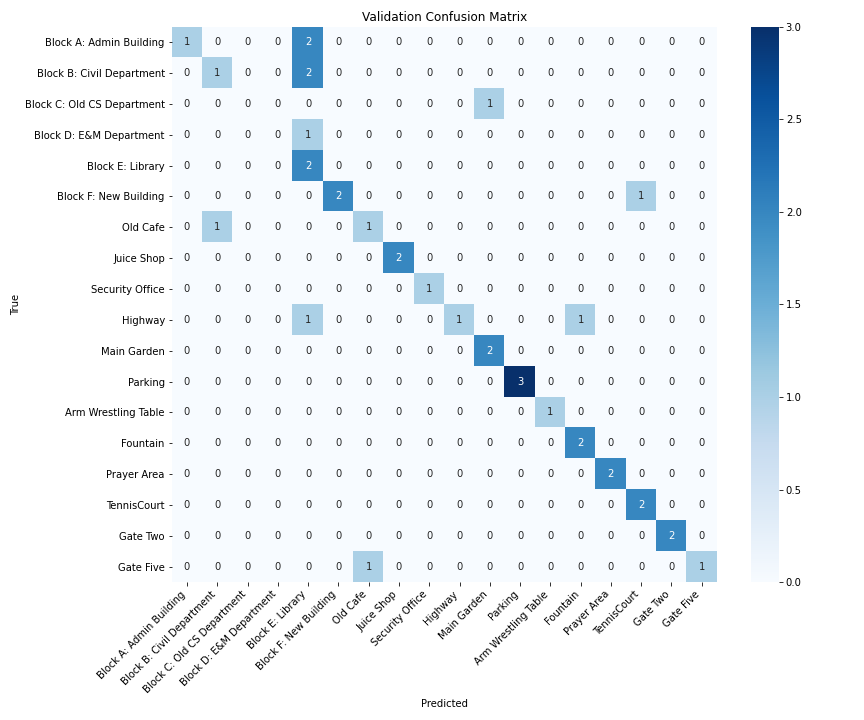

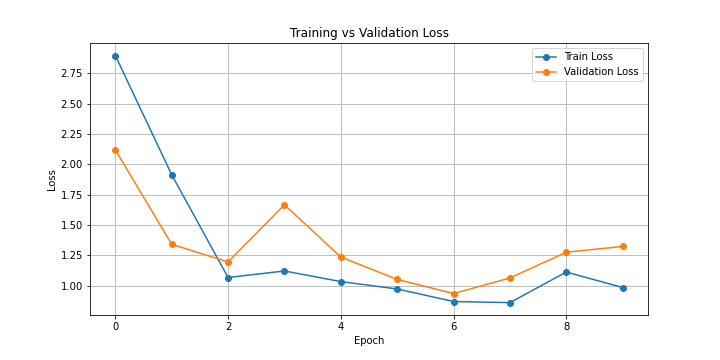

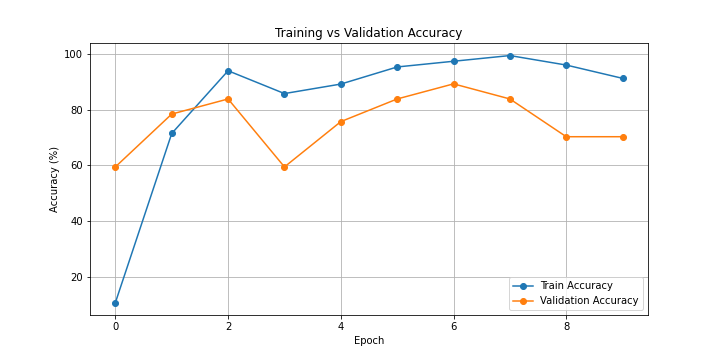

In [ ]:
from IPython.display import Image, display

# Define paths
base_path = r'C:\Users\iuser\Downloads\model'
display(Image(filename=base_path + r'\val_confusion_matrix_multiclass.png'))
display(Image(filename=base_path + r'\loss_curve_multiclass.png'))
display(Image(filename=base_path + r'\accuracy_curve_multiclass.png'))


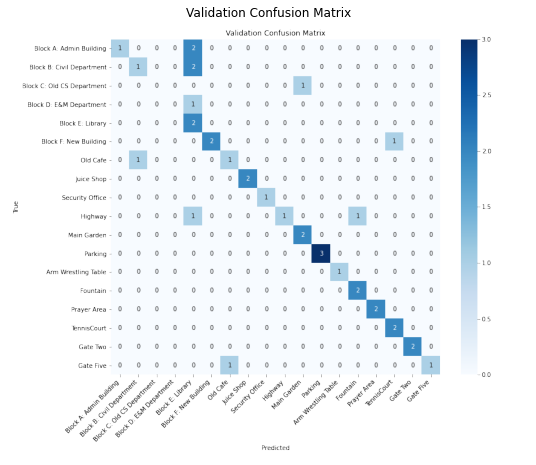

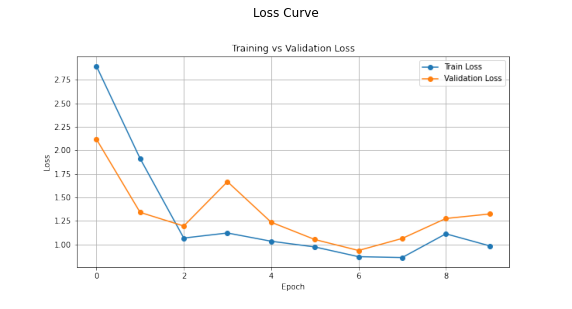

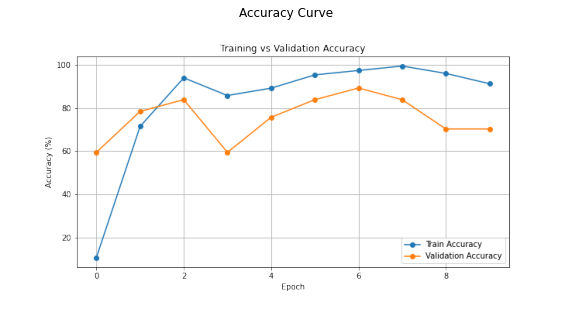

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define paths
base_path = r'C:\Users\iuser\Downloads\model'
conf_matrix_path = base_path + r'\val_confusion_matrix_multiclass.png'
loss_curve_path = base_path + r'\loss_curve_multiclass.png'
accuracy_curve_path = base_path + r'\accuracy_curve_multiclass.png'

# Display Confusion Matrix
img = mpimg.imread(conf_matrix_path)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title("Validation Confusion Matrix")
plt.show()

# Display Loss Curve
img = mpimg.imread(loss_curve_path)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Loss Curve")
plt.show()

# Display Accuracy Curve
img = mpimg.imread(accuracy_curve_path)
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.title("Accuracy Curve")
plt.show()
